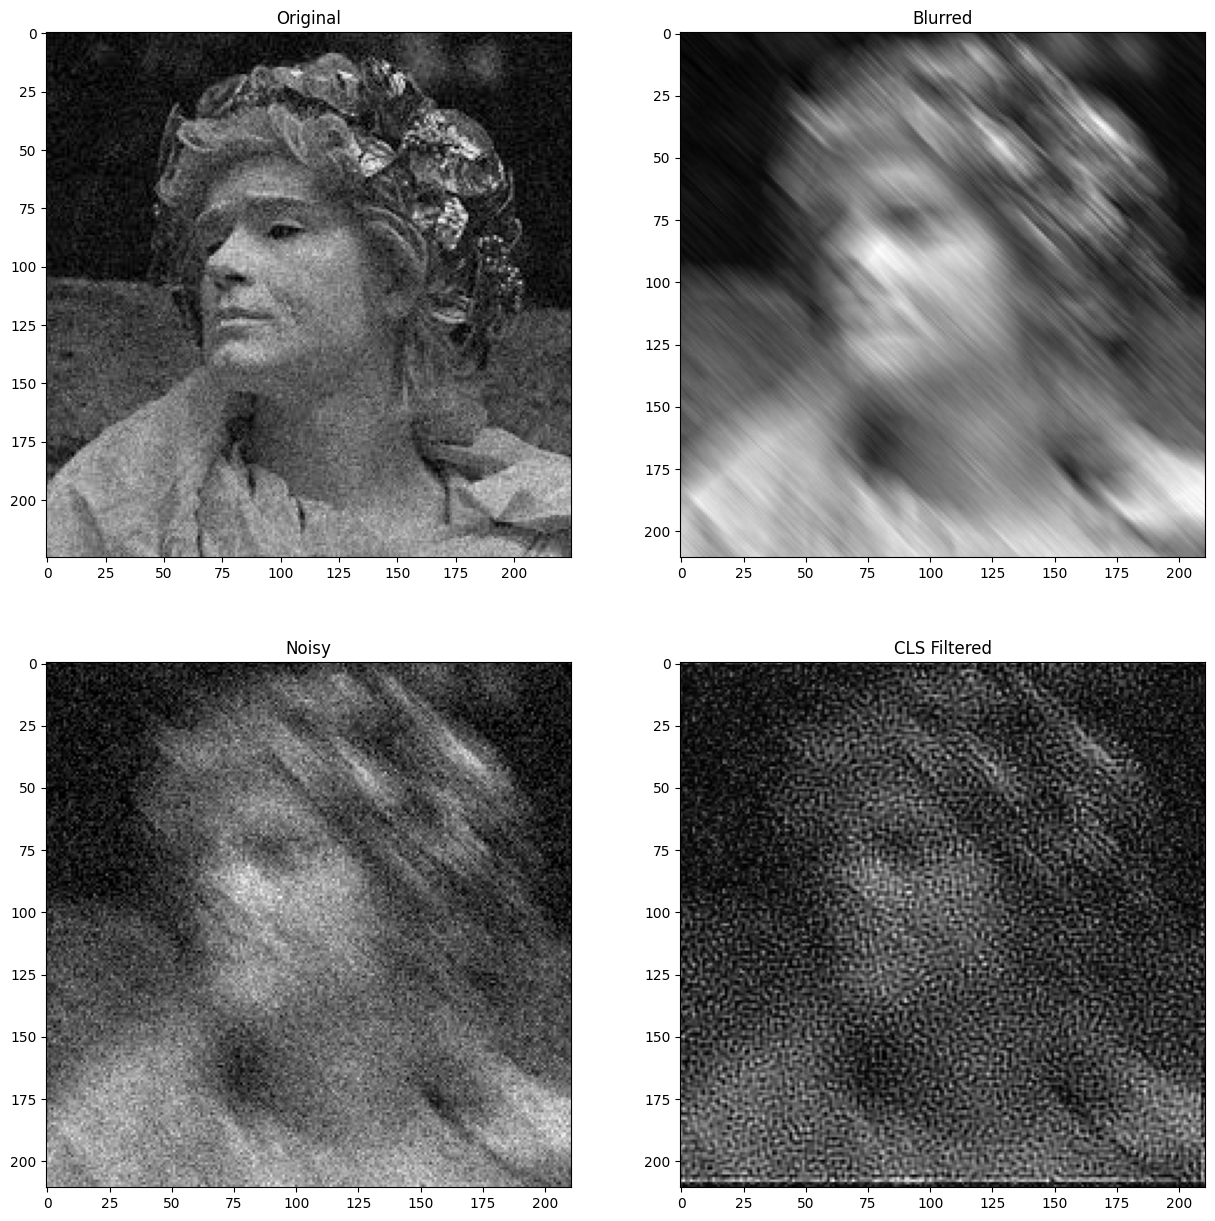

In [5]:
import os
import cv2
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal.windows import gaussian
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

filename = 'noise.jpeg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def blur(img, kernel_size=3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode='valid')
    return dummy

def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def constrained_least_squares_filter(img, kernel, gamma, P):

    kernel /= np.sum(kernel)
    dummy = np.copy(img)


    dummy = fft2(dummy)
    kernel = fft2(kernel, s=img.shape)
    P = fft2(P, s=img.shape)


    kernel_conj = np.conj(kernel)
    denominator = (kernel_conj * kernel) + gamma * (np.conj(P) * P)
    dummy = (kernel_conj * dummy) / denominator


    dummy = np.abs(ifft2(dummy))
    return dummy

def laplacian_operator(size):

    laplacian = np.zeros((size, size))
    laplacian[size//2, size//2] = 4
    laplacian[size//2-1, size//2] = -1
    laplacian[size//2+1, size//2] = -1
    laplacian[size//2, size//2-1] = -1
    laplacian[size//2, size//2+1] = -1
    return laplacian

def gaussian_kernel(kernel_size):
    kernel_1d = gaussian(kernel_size, std=1)
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d / np.sum(kernel_2d)

if __name__ == '__main__':
    blurred_img = blur(img, kernel_size=15)
    noisy_img = add_gaussian_noise(blurred_img, sigma=20)

    kernel = gaussian_kernel(kernel_size=5)
    P = laplacian_operator(size=5)
    gamma = 0.001

    filtered_img_cls = constrained_least_squares_filter(noisy_img, kernel, gamma, P)

    display = [img, blurred_img, noisy_img, filtered_img_cls]
    titles = ['Original', 'Blurred', 'Noisy', 'CLS Filtered']

    fig = plt.figure(figsize=(15, 15))
    for i in range(len(display)):
        fig.add_subplot(2, 2, i + 1)
        plt.imshow(display[i], cmap='gray')
        plt.title(titles[i])

    plt.show()
